In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


In [5]:
y, sr = librosa.load('segmented_files/segmento_47.mpeg')

'''sample rate, que se refere à taxa de amostragem do áudio. 
A taxa de amostragem é o número de amostras de áudio coletadas 
por segundo quando o áudio é convertido de uma forma analógica 
para uma forma digital'''

C:\Users\felip\AppData\Local\Temp\ipykernel_11688\4204197565.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load('segmented_files/segmento_47.mpeg')
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


'sample rate, que se refere à taxa de amostragem do áudio. \nA taxa de amostragem é o número de amostras de áudio coletadas \npor segundo quando o áudio é convertido de uma forma analógica \npara uma forma digital'

In [6]:
# Set the hop length; at 22050 Hz, 512 samples ~= 23ms
hop_length = 512 # 512 é uma potencia de 2 e facilita a transformada de fourier

y_harmonic, y_percussive = librosa.effects.hpss(y)

In [7]:
#Identificando o andamento
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
print(tempo)

117.45383522727273


O tempo deveria ser 70, mas faz sentido que tenha identificado dobrado.

# Features:

In [8]:
# Compute MFCC features from the raw signal
# MFCC é uma tabela da distribuições das frequencias pelo tempo
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

In [9]:
n_frames = mfcc.shape[1]  # Assumindo que mfcc.shape[0] é o número de coeficientes
width = n_frames if n_frames % 2 else n_frames - 1  # A largura deve ser um número ímpar

In [10]:
# the first-order differences (delta features)
mfcc_delta = librosa.feature.delta(mfcc, width = width)

In [11]:
# Stack and synchronize between beat events
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]),
                                    beat_frames)

In [12]:
# Compute chroma features from the harmonic signal
# Transforma cada faixa de frequencia em notas musicais
chromagram = librosa.feature.chroma_cqt(y=y_harmonic,
                                        sr=sr)

c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=927
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=464
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=232
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=116
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=58
  warnings.warn(


In [13]:
# Aggregate chroma features between beat events
# We'll use the median value of each feature between beat frames
beat_chroma = librosa.util.sync(chromagram,
                                beat_frames,
                                aggregate=np.median)

In [14]:
# stack all beat-synchronous features together
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

# Espectrograma
Em HZ

In [15]:
#Aplicando a transformada de fourier no segmento harmonico
D = np.abs(librosa.stft(y_harmonic))

In [16]:
# transformando a amplitude do sinal em decibeis
DB = librosa.amplitude_to_db(D, ref=np.max)

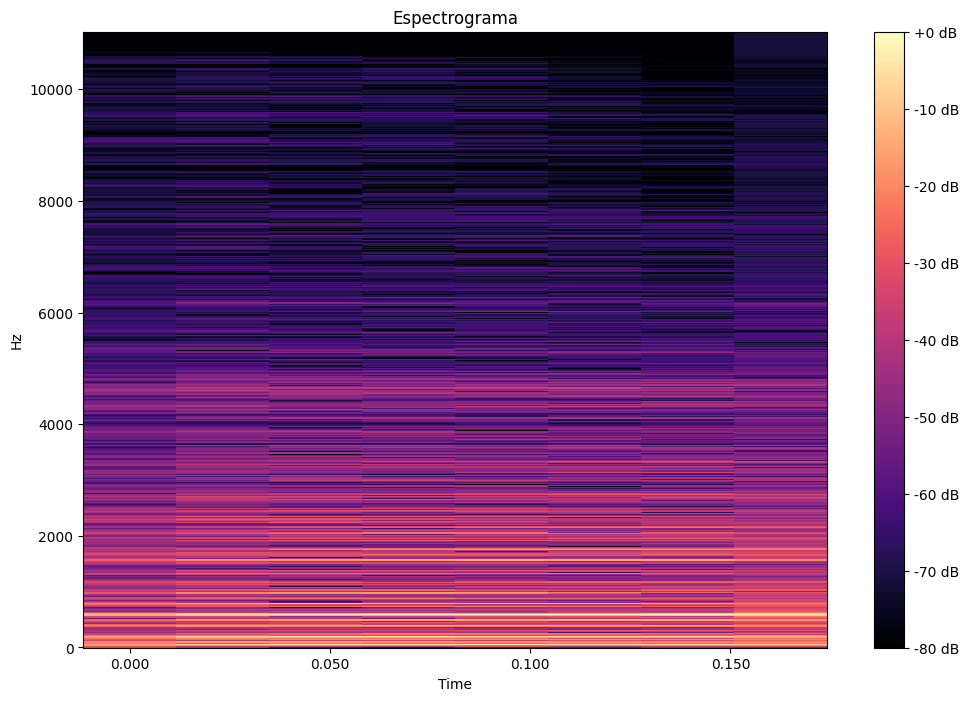

In [17]:
# plotando espectrograma
plt.figure(figsize=(12, 8))
librosa.display.specshow(DB, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma')
plt.show()

Em notas musicais

In [18]:
chromagram

array([[0.14697783, 0.13977785, 0.13411558, 0.13925493, 0.13794503,
        0.13632946, 0.16396068, 0.2001983 ],
       [0.10674302, 0.09531709, 0.07219811, 0.07986181, 0.09196537,
        0.09321029, 0.11363898, 0.18409725],
       [0.3168015 , 0.47308224, 0.48800156, 0.51342696, 0.5714745 ,
        0.62814033, 0.68948627, 0.62218195],
       [0.19721304, 0.16423982, 0.13100852, 0.1360772 , 0.13355742,
        0.12432285, 0.15393391, 0.24114144],
       [0.10330559, 0.10622804, 0.09256753, 0.09127863, 0.08646134,
        0.08794814, 0.09535318, 0.12344351],
       [0.15878604, 0.14007339, 0.1245379 , 0.1155159 , 0.11490031,
        0.11668683, 0.12029878, 0.15246895],
       [0.486237  , 0.40434545, 0.35977384, 0.3456451 , 0.33628058,
        0.3374033 , 0.36724627, 0.44303533],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        ],
       [0.49820027, 0.40944245, 0.36383924, 0.3471283 , 0.3428649 ,
        0.35374647, 0.396105

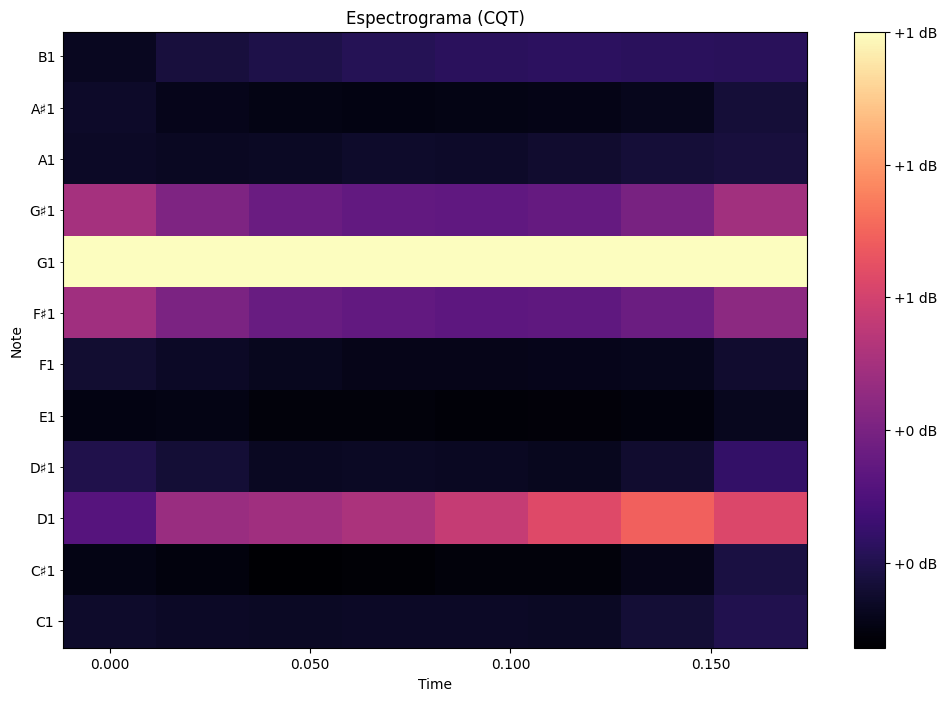

In [19]:
# Plot o espectrograma com o chroma_cqt
plt.figure(figsize=(12, 8))
librosa.display.specshow(chromagram, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (CQT)')
plt.show()

acordes estão mudando a cada 2.5 segundos

c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=232
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=116
  warnings.warn(
c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=256 is too large for input signal of length=58
  warnings.warn(


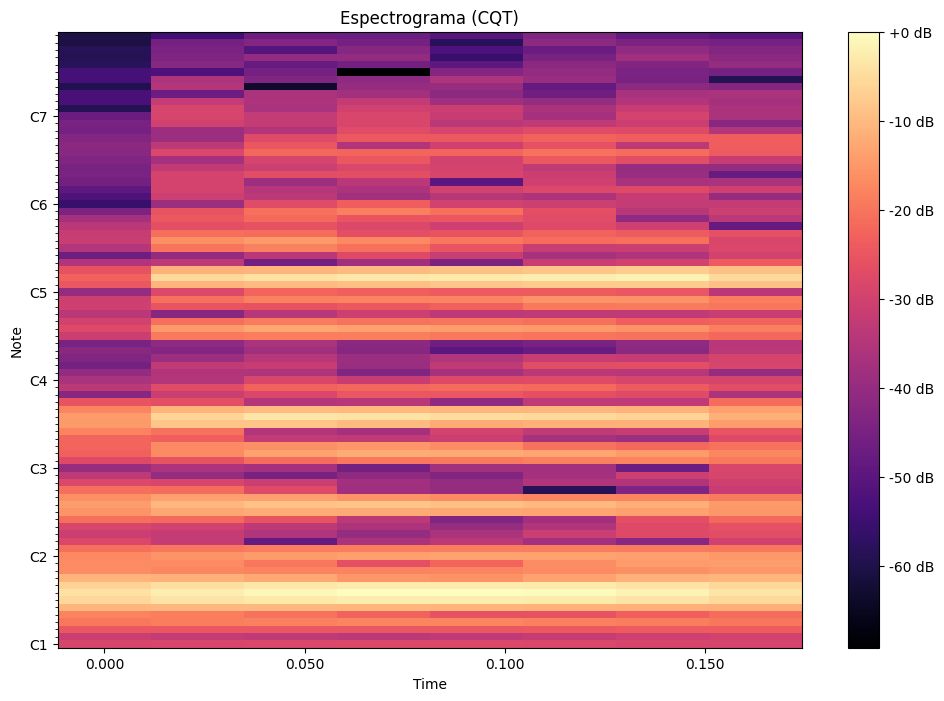

In [20]:
# Calcule o CQT (Constant-Q transform)
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y_harmonic, sr=sr)), ref=np.max)

# Plot o espectrograma com o cqt
plt.figure(figsize=(12, 8))
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma (CQT)')
plt.show()